# ⚽S4E1 - Gluon

Welcome to 2024! For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

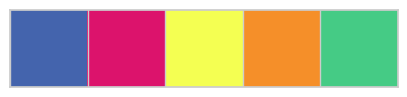

In [4]:
# essentials
import os
import pathlib
from copy import copy
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, TweedieRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

import optuna
import shap

RANDOM_SEED = 64

palette = ["#4464ad", "#dc136c", "#F4FF52", "#f58f29","#45cb85"]

sns.set_theme(style="whitegrid")
sns.set_palette(palette)
sns.palplot(palette)

## Data loading & EDA

First we will check

1. Number and types of columns
2. Number of rows in train and test
2. Missing values
3. Target variable distribution

In [5]:
IN_KAGGLE = True

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
input_folder = kaggle_folder if IN_KAGGLE else local_folder
output_folder = "/kaggle/output/" if IN_KAGGLE else "./"

train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

GENERATED_COLUMN = True
ADD_ORIGINAL_DF = True

model_postfix = "_with_original" if ADD_ORIGINAL_DF else ""
model_postfix += "_generated" if GENERATED_COLUMN else ""

original_df = original_df.drop(columns=['RowNumber'])

# drop na rows from orignal df
original_df = original_df.dropna()

if GENERATED_COLUMN:
    train_df['generated'] = 1
    test_df['generated'] = 1
    original_df['generated'] = 0
    categorical_features.append('generated')
    
if ADD_ORIGINAL_DF:
    train_df = pd.concat([train_df, original_df])


for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    #df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")
    # encode geography
    #df = pd.get_dummies(df, columns=['Geography'])

    return df

def feature_engineering_1(df):
    # Balance
    df['balance_over_100k'] = df['Balance'] >= 100000
    df['balance_over_150k'] = df['Balance'] >= 150000

    # EstimatedSalary
    df["estimated_salary_under_50k"] = df["EstimatedSalary"] < 50000
    df["estimated_salary_50k_to_100k"] = (df["EstimatedSalary"] >= 50000) & (df["EstimatedSalary"] < 100000)
    df["estamated_salary_over_150k"] = df["EstimatedSalary"] >= 150000

    # NumOfProducts
    df["num_of_products_3_or_4"] = df["NumOfProducts"] >= 3

    # Age
    df["age_over_40"] = df["Age"] >= 40
    df["age_over_50"] = df["Age"] >= 50
    df["age_over_60"] = df["Age"] >= 60

    new_features = [
        "balance_over_100k",
        "balance_over_150k",
        "estimated_salary_under_50k",
        "estimated_salary_50k_to_100k",
        "estamated_salary_over_150k",
        "num_of_products_3_or_4",
        "age_over_40",
        "age_over_50",
        "age_over_60",
    ]
    for f in new_features:
        df[f] = df[f].astype("int")

    return df

train_df = initial_feature_engineering(train_df)
#train_df = feature_engineering_1(train_df)

X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=target_col), train_df[target_col], test_size=0.4, random_state=RANDOM_SEED, stratify=train_df[target_col])

## Ideas for feature engineering

In [40]:
def create_pipeline(model, numeric_scalers=("scaler", StandardScaler())):
    numeric_pipeline = Pipeline(
        [numeric_scalers]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_features),
        #("categorical", categorical_pipeline, categorical_features),
    ], remainder='passthrough')

    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])

def train_models(models, X_train, y_train, parameters={}):
    trained_models = {}
    for model_name, model in tqdm(models.items()):
        if model_name in parameters:
            model.set_params(**parameters[model_name])
        model = create_pipeline(model)
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

def evaluate_models(models, X_val, y_val):
    # create a dataframe with "model_name", "accuracy", "precision", "recall", "area under the ROC curve"
    results_df = pd.DataFrame(columns=["model_name", "accuracy", "precision", "recall", "auc"])

    for model_name, model in tqdm(models.items()):
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                "model_name": [model_name],
                "accuracy": [model.score(X_val, y_val)],
                "precision": [sklearn.metrics.precision_score(y_val, y_pred)],
                "recall": [sklearn.metrics.recall_score(y_val, y_pred)],
                "auc": [sklearn.metrics.roc_auc_score(y_val, y_proba)],
            })
        ])
    return results_df

def plot_roc_curve(models, X_val, y_val):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    palette_to_use = sns.color_palette("husl", len(models))
    # for each model, plot the roc curve in the same plot, with other color
    for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color=palette_to_use[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    # show legend
    ax.legend()


## Gluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor


gluon_train_df = X_train.copy()
gluon_train_df[target_col] = y_train

gluon_val_df = X_val.copy()
gluon_val_df[target_col] = y_val

train_data = TabularDataset(gluon_train_df)
val_data = TabularDataset(gluon_val_df)

label = target_col

predictor = TabularPredictor(label=label, eval_metric='roc_auc').fit(train_data)
predictor.evaluate(val_data, silent=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20240108_152104"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240108_152104"
=================== System

{'roc_auc': 0.8884477293978813,
 'accuracy': 0.8641966491937212,
 'balanced_accuracy': 0.7472144714276622,
 'mcc': 0.5580469464842133,
 'f1': 0.6287967517763723,
 'precision': 0.7435826408125578,
 'recall': 0.5447104978354979}

In [ ]:
predictor.leaderboard(val_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.888448,0.891729,roc_auc,1.304070,0.242181,18.144470,0.004278,0.000538,0.477773,2,True,14
1,CatBoost,0.888237,0.890079,roc_auc,0.055577,0.002537,6.581679,0.055577,0.002537,6.581679,1,True,7
2,LightGBM,0.888181,0.890206,roc_auc,0.059850,0.005121,1.001610,0.059850,0.005121,1.001610,1,True,4
3,XGBoost,0.887780,0.889509,roc_auc,0.075617,0.007329,0.647997,0.075617,0.007329,0.647997,1,True,11
4,LightGBMLarge,0.887562,0.891222,roc_auc,0.162201,0.042486,2.374122,0.162201,0.042486,2.374122,1,True,13
5,LightGBMXT,0.887396,0.890296,roc_auc,0.172759,0.008590,2.106066,0.172759,0.008590,2.106066,1,True,3
6,NeuralNetFastAI,0.886950,0.888019,roc_auc,0.630671,0.024803,71.849522,0.630671,0.024803,71.849522,1,True,10
7,NeuralNetTorch,0.885896,0.888776,roc_auc,0.309055,0.010098,40.186801,0.309055,0.010098,40.186801,1,True,12
8,ExtraTreesGini,0.881253,0.884434,roc_auc,0.638494,0.176742,2.218977,0.638494,0.176742,2.218977,1,True,8
9,ExtraTreesEntr,0.880519,0.882325,roc_auc,0.680704,0.174704,2.003752,0.680704,0.174704,2.003752,1,True,9


# Submission

In [6]:
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

GENERATED_COLUMN = True
ADD_ORIGINAL_DF = True

model_postfix = "_with_original" if ADD_ORIGINAL_DF else ""
model_postfix += "_generated" if GENERATED_COLUMN else ""

original_df = original_df.drop(columns=['RowNumber'])

# drop na rows from orignal df
original_df = original_df.dropna()

if GENERATED_COLUMN:
    train_df['generated'] = 1
    test_df['generated'] = 1
    original_df['generated'] = 0
    categorical_features.append('generated')
    
if ADD_ORIGINAL_DF:
    train_df = pd.concat([train_df, original_df])


for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)
    test_df = test_df.drop(columns=f)

train_df = initial_feature_engineering(train_df)
train_df = feature_engineering_1(train_df)

test_df = initial_feature_engineering(test_df)
test_df = feature_engineering_1(test_df)

In [12]:
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from autogluon.tabular import TabularDataset, TabularPredictor

train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

label = target_col

auto_ml_pipeline_feature_generator = AutoMLPipelineFeatureGenerator()
auto_ml_pipeline_feature_generator.fit_transform(X=train_data)

model = TabularPredictor(label=label, eval_metric='roc_auc')
# time limit should be 15 minutes

model.fit(train_data, presets='best_quality', feature_generator=auto_ml_pipeline_feature_generator, time_limit=60*15)

Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    20003.99 MB
	Train Data (Original)  Memory Usage: 45.21 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 14 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('bool', [])   :  2 | ['HasCrCard', 'IsActiveMember']
		('float', [])  :  3 | ['Age', 'Balance', 'EstimatedSalary']
		('int', [])    : 14 | ['CreditScore

KeyboardInterrupt: 

In [ ]:
model.fit_summary()

AssertionError: Predictor is not fit. Call `.fit` before calling `.fit_summary`.

In [ ]:
model.leaderboard(train_data)

Use for comparison or blending with other predictions:

In [ ]:
# predict on test data
y_predproba = model.predict_proba(test_data)

# create submission df

submission_df = pd.DataFrame({
    "id": test_df.index,
    target_col: y_predproba
})
submission_df.to_csv(f"{output_folder}/submission.csv", index=False)
submission_df